In [ ]:
from torch.utils.data import default_collate
def collate_function(batch,frames_per_video=3):
    """Collate function for PyTorch DataLoader."""
    # Transpose the data to shape (BATCH x NUM_FRAMES x CHANNELS x HEIGHT x WIDTH)
    # batch = list(zip(*batch))
    # batch[0] = torch.stack(batch[0], 0)
    batch= default_collate(batch)
    #print("BEFORE:",batch[1].shape)
    batch[0] = torch.flatten(batch[0], start_dim=0, end_dim=1) #Attacca i frame di video diversi
    batch[1] = torch.repeat_interleave(batch[1], frames_per_video, dim=0) #Attacca le label di video diversi
    #print("AFTER:",batch[1].shape)
    #print("")
    return batch

In [ ]:

torch.repeat_interleave(torch.tensor([0, 1, 1, 0]), 3, dim=0)

In [ ]:
import albumentations
dataset_train_mode, dataset_test_mode = get_dataset_training_test_modes()

In [ ]:
import torch
import torch.nn.functional as F

def myresize(tensor, target_size):
    """This function resizes a tensor to a target size while keeping the aspect ratio."""
    c, h, w = tensor.size()
    if h != w:
        max_dim = max(h, w)
        if h == max_dim:
            factor = target_size / h
            
            pad_width = (target_size-int(factor * w )) // 2
            pad_height = 0
            resized_tensor = F.interpolate(tensor.unsqueeze(0), size=(target_size, int(factor * w)), mode='bilinear', align_corners=False)
            
        else:
            factor = target_size / w
           
            pad_height =(target_size - int(factor * h ) )// 2
            pad_width = 0
            resized_tensor = F.interpolate(tensor.unsqueeze(0), size=(int(factor * h), target_size), mode='bilinear', align_corners=False)
            
    else:
        pad_width = 0
        pad_height = 0
        resized_tensor = F.interpolate(tensor.unsqueeze(0), size=(target_size, target_size), mode='bilinear', align_corners=False)
   
    padded_tensor = F.pad(resized_tensor, pad=(pad_width, pad_width, pad_height,pad_height), mode='constant', value=0)
    
    return padded_tensor.squeeze()

In [ ]:
lossFunction = torch.nn.CrossEntropyLoss()

lr = .01
momentum = .9
lambda_reg = 0

epochs = 100
early_stopping_patience = 40

In [ ]:
from utils.models import get_config
import importlib

importlib.reload(model_module)

selected_model = 'YOLOv8n-cls'
num_classes = 2
batch_size = 64
epochs = 100
early_stopping_patience = 40


model_config = get_config(selected_model)
model_module = importlib.import_module(model_config['module_name'])
ModelClass = getattr(model_module, model_config['class_name'])


print("optimizer params:",model_config['optimizer_params'])
print("transforms:",model_config['preprocess_train'])



In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import utils.engine as engine
from models.resnet import resnet_sharma

preprocessing = model_config['preprocess_train']
dataset_train_mode, dataset_test_mode = get_dataset_training_test_modes(preprocessing=preprocessing)

import importlib
importlib.reload(engine)

split = KFold(n_splits=6, shuffle=True, random_state=42).split(dataset_train_mode)
for fold_index, (train_indexes, val_indexes) in enumerate(split):
    print(f"Fold {fold_index}:")
    #print(train_indexes, train_indexes.tolist())
    #
    #print(f"  Train: index={train_indexes}")
    #print(f"  Test:  index={val_indexes}")

    train_dataset = Subset(dataset_train_mode, train_indexes.tolist())
    val_dataset = Subset(dataset_test_mode, val_indexes.tolist())

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=8, pin_memory=True, collate_fn=collate_function)
    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=8, pin_memory=True, collate_fn=collate_function)

    model = ModelClass(classes=num_classes) #Il modello deve cambiare in base al fold
    
    optimizer = model_config['optimizer'](params=model.parameters(),**model_config['optimizer_params'])
    lossFunction = model_config['criterion']
    
    engine.train(model, train_dataloader, val_dataloader, optimizer, lossFunction, epochs, torch.device("cuda"),"experiments/resnet50-test/foggia-mod/test", fold_index, early_stopping_patience)

#TODO: NORMALIZZARE I DATI PER IL TRAINING DI RESNET

In [119]:

from sklearn.model_selection import KFold




In [ ]:
from utils.dataset_analysis import extract_clusters_dataframe
import pandas as pd
clusters_data = extract_clusters_dataframe("datasets/dfire_firesense_kmu_foggia.json")
clusters_data["VideoName"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: ', '.join(x))
clusters_data["VideoNumber"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: len(x))
clusters_data = clusters_data.drop_duplicates(subset=["GroupId","Dataset","Class"])
clusters_data = clusters_data.sort_values(["Dataset","Class"]).drop(columns=["Path", "Folder"]).groupby(["GroupId","Dataset","Class"]).sum()
#clusters_data = clusters_data[["GroupId", "Dataset", "Class", "VideoName"]]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pd.set_option('display.max_colwidth', None)
    display(clusters_data)

# Creare un dizionario con il nome del dataset come chiave e un dizionario con la classe come chiave e l'elenco dei video come valore come valore
datasets_dict = {}
for dataset in clusters_data.index.get_level_values("Dataset").unique():
    dataset_dict = {}
    dataset_clusters = clusters_data.xs(dataset, level="Dataset")
    for classe in dataset_clusters.index.get_level_values("Class").unique():
        classe_clusters = dataset_clusters.xs(classe, level="Class")
        videos = classe_clusters["VideoName"].str.split(",").explode().str.strip().unique()
        dataset_dict[classe] = list(videos)
    datasets_dict[dataset] = dataset_dict

# Visualizzare il dizionario risultante
for dataset, classes_dict in datasets_dict.items():
    print(f"{dataset}:")
    for classe, videos in classes_dict.items():
        print(f"    {classe}: {len(videos)} video")
        print(f"        {videos}")


## Estensione del Dataset

Crea i folder per l'estensione

In [6]:
import os

selected_dataset = "potentialy_extension"
dataset_folder = "datasets/" + selected_dataset

# Crea le cartelle solo se non esistono già
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder + "/VIDEOS/TRAINING_SET/0")
    os.makedirs(dataset_folder + "/VIDEOS/TRAINING_SET/1")
    os.makedirs(dataset_folder + "/GT/TRAINING_SET/0")
    os.makedirs(dataset_folder + "/GT/TRAINING_SET/1")

Analizza il data frame derivata da json per verificare i dati che possono essere aggiunti

In [7]:
import os

def create_videos_dict( datasets):
    
    datasets_dict = {}
    for dataset in datasets:
        folder_path = "datasets/"+dataset+"/VIDEOS/TRAINING_SET"
        dataset_dict = {}
        #dataset_path = os.path.join(folder_path, str(dataset))
        for folder in os.listdir(folder_path):
            if folder in ('0', '1'):
                folder_path_plus = os.path.join(folder_path, folder)
                #print(folder_path)
                class_name = '0' if folder == '0' else '1'
                class_videos = [f for f in os.listdir(folder_path_plus) if os.path.isfile(os.path.join(folder_path_plus, f))]
                dataset_dict[class_name] = class_videos
        datasets_dict[dataset] = dataset_dict
    return datasets_dict

In [8]:
selected_datasets = ["kmu", "dfire", "firesense"]
dict_complete = create_videos_dict(selected_datasets)
for dataset, classes_dict in dict_complete.items():
    print(f"{dataset}:")
    for classe, videos in classes_dict.items():
        print(f"    {classe}: {len(videos)} video")
        print(f"        {videos}")

kmu:
    1: 28 video
        ['wildfire_smoke_2.avi', 'wildfire_smoke_4.avi', 'indoor_night_20m_heptane_CCD_002.avi', 'outdoor_night_10m_gasoline_CCD_001.avi', 'outdoor_night_20m_heptane_CCD_002.avi', 'outdoor_night_30m_gasoline_CCD_001.avi', 'indoor_daytime_smoke.avi', 'wildfire_smoke_3.avi', 'outdoor_daytime_10m_gasoline_CCD_001.avi', 'outdoor_daytime_20m_gasoline_CCD_001.avi', 'outdoor_daytime_30m_heptane_CCD_001.avi', 'flame4.avi', 'outdoor_daytime_20m_heptane_CCD_001.avi', 'outdoor_night_10m_heptane_CCD_002.avi', 'flame5.avi', 'outdoor_night_10m_gasoline_CCD_002.avi', 'outdoor_daytime_30m_gasoline_CCD_001.avi', 'indoor_night_smoke.avi', 'outdoor_night_30m_heptane_CCD_001.avi', 'flame1.avi', 'outdoor_night_20m_gasoline_CCD_001.avi', 'outdoor_night_20m_heptane_CCD_001.avi', 'outdoor_daytime_10m_heptane_CCD_001.avi', 'wildfire_smoke_1.avi', 'indoor_night_20m_heptane_CCD_001.avi', 'flame2.avi', 'outdoor_night_10m_heptane_CCD_001.avi', 'flame3.avi']
    0: 10 video
        ['smoke_or_f

In questa fase creiamo un dizionario contenente solo i video che hanno superato il test di replicazione dei dataset

In [24]:

diff_dict={}

for dataset, classes_dict in dict_complete.items():
    if dataset in datasets_dict:
        diff_classes_dict = {}
        for classe, videos in classes_dict.items():
            if classe in datasets_dict[dataset]:
                diff_videos = list(set(videos) - set(datasets_dict[dataset][classe]))
                if diff_videos:
                    diff_classes_dict[classe] = diff_videos
        if diff_classes_dict:
            diff_dict[dataset] = diff_classes_dict
diff_dict["dfire"]['0'].remove('FP18.mp4')
class_0 = 0
class_1 = 0
for dataset, classes_dict in diff_dict.items():
    print(f"{dataset}:")
    
    for classe, videos in classes_dict.items():
        if classe == "1":
            class_1 += len(videos)
        else:
            class_0+=len(videos)
        print(f"    {classe}: {len(videos)} video")
        print(f"        {videos}")
print(class_0)
print(class_1)
print(class_0+class_1)
print(class_0/(class_1+class_0))

kmu:
    1: 6 video
        ['flame2.avi', 'flame3.avi', 'flame5.avi', 'indoor_daytime_smoke.avi', 'indoor_night_smoke.avi', 'flame4.avi']
    0: 2 video
        ['smoke_or_flame_like_object_2.avi', 'smoke_or_flame_like_object_5.avi']
dfire:
    0: 37 video
        ['FP3.mp4', 'FP29.mp4', 'FP5.mp4', 'FP19.mp4', 'FP12.mp4', 'FP33.mp4', 'FP49.mp4', 'FP42.mp4', 'FP13.mp4', 'FP35.mp4', 'FP17.mp4', 'FP26.mp4', 'FP1.mp4', 'FP47.mp4', 'FP50.mp4', 'FP23.mp4', 'FP45.mp4', 'FP14.mp4', 'FP6.mp4', 'FP37.mp4', 'FP41.mp4', 'FP40.mp4', 'FP16.mp4', 'FP25.mp4', 'FP38.mp4', 'FP7.mp4', 'FP43.mp4', 'FP4.mp4', 'FP11.mp4', 'FP48.mp4', 'FP44.mp4', 'FP39.mp4', 'FP34.mp4', 'FP2.mp4', 'FP30.mp4', 'FP36.mp4', 'FP27.mp4']
firesense:
    1: 11 video
        ['testpos13.829.avi', 'testpos01.817.avi', 'testpos10.826.avi', 'testpos12.828.avi', 'posVideo7.876.avi', 'testpos11.827.avi', 'testpos09.825.avi', 'posVideo9.878.avi', 'testpos04.820.avi', 'posVideo8.877.avi', 'posVideo2.871.avi']
    0: 8 video
        ['negs

Cloniamo i dataset da estendere

In [10]:
from utils.prepare_datasets import *
folder_dataset = "datasets/foggia-unbalanced"
destination_folder= "datasets/foggia-unbalanced-ext"
copy_folder(folder_dataset, destination_folder)

A partire da un dataset salvo i dati in una struttura di folder come i nostri dataset

In [11]:
import os
import shutil

def copy_videos_and_rtf_files(folder_path, false, smoke, fire, file_dict, dest_folder_path):
    for folder_name in os.listdir(folder_path):
        print(folder_name)
        video_has_fire = fire in folder_name.lower()
        video_has_smoke = smoke in folder_name.lower()
        print(video_has_fire)
        print(video_has_smoke)
        if false in folder_name.lower():
            #print(folder_pathname)
            folder_pathname = os.path.join(folder_path, folder_name)
            for video_name in os.listdir(folder_pathname):
                if video_name in file_dict:
                    video_pathname = os.path.join(folder_pathname, video_name)
                    rtf_filename = os.path.splitext(video_name)[0] + ".rtf"
                    rtf_path = os.path.join(dest_folder_path, "GT/TRAINING_SET/0", rtf_filename)
                    if not os.path.exists(rtf_path):
                        # crea il file RTF con il primo campo "0,Fire"
                        with open(rtf_path, "w") as f:
                            f.write("")
                    video_dest_pathname = os.path.join(dest_folder_path+"/VIDEOS/TRAINING_SET/0", video_name)
                    shutil.copy(video_pathname, video_dest_pathname)
        elif video_has_fire:
            folder_pathname = os.path.join(folder_path, folder_name)
            for video_name in os.listdir(folder_pathname):
                if video_name in file_dict:
                    video_pathname = os.path.join(folder_pathname, video_name)
                    rtf_filename = os.path.splitext(video_name)[0] + ".rtf"
                    rtf_path = os.path.join(dest_folder_path, "GT/TRAINING_SET/1", rtf_filename)
                    if not os.path.exists(rtf_path):
                        # crea il file RTF con il primo campo "0,Fire"
                        with open(rtf_path, "w") as f:
                            f.write('0,Fire')
                    video_dest_pathname = os.path.join(dest_folder_path+"/VIDEOS/TRAINING_SET/1", video_name)
                    shutil.copy(video_pathname, video_dest_pathname)
        elif video_has_smoke:
            folder_pathname = os.path.join(folder_path, folder_name)
            for video_name in os.listdir(folder_pathname):
                if video_name in file_dict:
                    video_pathname = os.path.join(folder_pathname, video_name)
                    rtf_filename = os.path.splitext(video_name)[0] + ".rtf"
                    rtf_path = os.path.join(dest_folder_path, "GT/TRAINING_SET/1", rtf_filename)
                    if not os.path.exists(rtf_path):
                        # crea il file RTF con il primo campo "0,Fire"
                        with open(rtf_path, "w") as f:
                            f.write('0,Smoke')
                    video_dest_pathname = os.path.join(dest_folder_path+"/VIDEOS/TRAINING_SET/1", video_name)
                    shutil.copy(video_pathname, video_dest_pathname)

Inserisci i dati di KMU

In [12]:
selected_dataset = "kmu_original"
key_dataset  = "kmu"
folder_path = "datasets/"+selected_dataset
false = "others"
fire = "flame"
smoke = "smoke"
new_dataset = "potentialy_extension"
dest_path = "datasets/"+new_dataset
file_dict = []
# Verifica se la chiave [0] esiste in diff_dict[key_dataset]["0"]
if "0" in diff_dict[key_dataset]:
    if "1" in diff_dict[key_dataset]:
        file_dict = diff_dict[key_dataset]["0"]+diff_dict[key_dataset]["1"]
        # La lista diff_dict[key_dataset]["0"] non è vuota
        # Esegui le operazioni necessarie
    
    else:
        # La lista diff_dict[key_dataset]["0"] è vuota
        # Esegui le operazioni necessarie
        file_dict = diff_dict[key_dataset]["0"]
else:
    # La chiave [0] non esiste in diff_dict[key_dataset]["0"]
    # Esegui le operazioni necessarie
    file_dict = diff_dict[key_dataset]["1"]
print(file_dict)
copy_videos_and_rtf_files(folder_path,false,smoke,fire,file_dict,dest_path)

['smoke_or_flame_like_object_2.avi', 'smoke_or_flame_like_object_5.avi', 'flame2.avi', 'flame3.avi', 'flame5.avi', 'indoor_daytime_smoke.avi', 'indoor_night_smoke.avi', 'flame4.avi']
wildfire-smoke
False
True
short-distance-smoke
False
True
short-distance-flame
True
False
others
False
False


Inserisci i dati di DFIRE

In [13]:
selected_dataset = "dfire_original"
key_dataset  = "dfire"
folder_path = "datasets/"+selected_dataset+"/VIDEOS/TRAINING_SET"
false = "0"
fire = "1"
smoke = "smoke"
new_dataset = "potentialy_extension"
dest_path = "datasets/"+new_dataset
file_dict = []
# Verifica se la chiave [0] esiste in diff_dict[key_dataset]["0"]
if "0" in diff_dict[key_dataset]:
    if "1" in diff_dict[key_dataset]:
        file_dict = diff_dict[key_dataset]["0"]+diff_dict[key_dataset]["1"]
        # La lista diff_dict[key_dataset]["0"] non è vuota
        # Esegui le operazioni necessarie
    
    else:
        # La lista diff_dict[key_dataset]["0"] è vuota
        # Esegui le operazioni necessarie
        file_dict = diff_dict[key_dataset]["0"]
else:
    # La chiave [0] non esiste in diff_dict[key_dataset]["0"]
    # Esegui le operazioni necessarie
    file_dict = diff_dict[key_dataset]["1"]
print(file_dict)
copy_videos_and_rtf_files(folder_path,false,smoke,fire,file_dict,dest_path)

['FP3.mp4', 'FP29.mp4', 'FP5.mp4', 'FP19.mp4', 'FP12.mp4', 'FP33.mp4', 'FP49.mp4', 'FP42.mp4', 'FP13.mp4', 'FP35.mp4', 'FP17.mp4', 'FP26.mp4', 'FP1.mp4', 'FP47.mp4', 'FP50.mp4', 'FP23.mp4', 'FP45.mp4', 'FP14.mp4', 'FP6.mp4', 'FP37.mp4', 'FP41.mp4', 'FP40.mp4', 'FP16.mp4', 'FP25.mp4', 'FP38.mp4', 'FP7.mp4', 'FP43.mp4', 'FP4.mp4', 'FP11.mp4', 'FP48.mp4', 'FP44.mp4', 'FP39.mp4', 'FP34.mp4', 'FP2.mp4', 'FP30.mp4', 'FP36.mp4', 'FP18.mp4', 'FP27.mp4']
1
True
False
0
False
False


Inserisci i dati di FIRESENSE

In [14]:
selected_dataset = "firesense_original"
key_dataset  = "firesense"
folder_path = "datasets/"+selected_dataset+"/fire"
false = "neg"
fire = "pos"
smoke = "smoke"
new_dataset = "potentialy_extension"
dest_path = "datasets/"+new_dataset
file_dict = []
# Verifica se la chiave [0] esiste in diff_dict[key_dataset]["0"]
if "0" in diff_dict[key_dataset]:
    if "0" in diff_dict[key_dataset]:
        file_dict = diff_dict[key_dataset]["1"]+diff_dict[key_dataset]["1"]
        # La lista diff_dict[key_dataset]["0"] non è vuota
        # Esegui le operazioni necessarie
    
    else:
        # La lista diff_dict[key_dataset]["0"] è vuota
        # Esegui le operazioni necessarie
        file_dict = diff_dict[key_dataset]["0"]
else:
    # La chiave [0] non esiste in diff_dict[key_dataset]["0"]
    # Esegui le operazioni necessarie
    file_dict = diff_dict[key_dataset]["1"]
print(file_dict)
copy_videos_and_rtf_files(folder_path,false,smoke,fire,file_dict,dest_path)

['testpos13.829.avi', 'testpos01.817.avi', 'testpos10.826.avi', 'testpos12.828.avi', 'posVideo7.876.avi', 'testpos11.827.avi', 'testpos09.825.avi', 'posVideo9.878.avi', 'testpos04.820.avi', 'posVideo8.877.avi', 'posVideo2.871.avi', 'testpos13.829.avi', 'testpos01.817.avi', 'testpos10.826.avi', 'testpos12.828.avi', 'posVideo7.876.avi', 'testpos11.827.avi', 'testpos09.825.avi', 'posVideo9.878.avi', 'testpos04.820.avi', 'posVideo8.877.avi', 'posVideo2.871.avi']
neg
False
False
pos
True
False


Inserisci i dati di FIRESENSE

In [15]:
selected_dataset = "firesense_original"
key_dataset  = "firesense"
folder_path = "datasets/"+selected_dataset+"/smoke"
false = "neg"
fire = "fire"
smoke = "pos"
new_dataset = "potentialy_extension"
dest_path = "datasets/"+new_dataset
file_dict = []
# Verifica se la chiave [0] esiste in diff_dict[key_dataset]["0"]
if "0" in diff_dict[key_dataset]:
    if "0" in diff_dict[key_dataset]:
        file_dict = diff_dict[key_dataset]["1"]+diff_dict[key_dataset]["1"]
        # La lista diff_dict[key_dataset]["0"] non è vuota
        # Esegui le operazioni necessarie
    
    else:
        # La lista diff_dict[key_dataset]["0"] è vuota
        # Esegui le operazioni necessarie
        file_dict = diff_dict[key_dataset]["0"]
else:
    # La chiave [0] non esiste in diff_dict[key_dataset]["0"]
    # Esegui le operazioni necessarie
    file_dict = diff_dict[key_dataset]["1"]

print(file_dict)
copy_videos_and_rtf_files(folder_path,false,smoke,fire,file_dict,dest_path)

['testpos13.829.avi', 'testpos01.817.avi', 'testpos10.826.avi', 'testpos12.828.avi', 'posVideo7.876.avi', 'testpos11.827.avi', 'testpos09.825.avi', 'posVideo9.878.avi', 'testpos04.820.avi', 'posVideo8.877.avi', 'posVideo2.871.avi', 'testpos13.829.avi', 'testpos01.817.avi', 'testpos10.826.avi', 'testpos12.828.avi', 'posVideo7.876.avi', 'testpos11.827.avi', 'testpos09.825.avi', 'posVideo9.878.avi', 'testpos04.820.avi', 'posVideo8.877.avi', 'posVideo2.871.avi']
neg
False
False
pos
False
True


In [16]:


import os
import ffmpeg

def convert_avi_to_mp4(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".avi"):
                avi_path = os.path.join(root, file)
                mp4_path = os.path.splitext(avi_path)[0] + ".mp4"
                stream = ffmpeg.input(avi_path)
                stream = ffmpeg.output(stream, mp4_path)
                ffmpeg.run(stream)
                os.remove(avi_path)

In [17]:
folder_path = "datasets/potentialy_extension"
convert_avi_to_mp4(folder_path)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [18]:
new_dataset="potentialy_extension"
videos_path = f"TRAINING_SET"
frames_path = f"FRAMES"
extract_frames(new_dataset,videos_path, frames_path)

TRAINING_SET
['TRAINING_SET/1/posVideo9.878.mp4', 'TRAINING_SET/1/posVideo2.871.mp4', 'TRAINING_SET/1/indoor_daytime_smoke.mp4', 'TRAINING_SET/1/flame2.mp4', 'TRAINING_SET/1/flame5.mp4', 'TRAINING_SET/1/testpos11.827.mp4', 'TRAINING_SET/1/testpos10.826.mp4', 'TRAINING_SET/1/testpos04.820.mp4', 'TRAINING_SET/1/flame4.mp4', 'TRAINING_SET/1/testpos13.829.mp4', 'TRAINING_SET/1/testpos01.817.mp4', 'TRAINING_SET/1/posVideo8.877.mp4', 'TRAINING_SET/1/testpos12.828.mp4', 'TRAINING_SET/1/indoor_night_smoke.mp4', 'TRAINING_SET/1/testpos09.825.mp4', 'TRAINING_SET/1/posVideo7.876.mp4', 'TRAINING_SET/1/flame3.mp4', 'TRAINING_SET/0/FP3.mp4', 'TRAINING_SET/0/FP36.mp4', 'TRAINING_SET/0/FP14.mp4', 'TRAINING_SET/0/FP17.mp4', 'TRAINING_SET/0/FP33.mp4', 'TRAINING_SET/0/FP7.mp4', 'TRAINING_SET/0/FP50.mp4', 'TRAINING_SET/0/FP39.mp4', 'TRAINING_SET/0/FP35.mp4', 'TRAINING_SET/0/FP11.mp4', 'TRAINING_SET/0/FP25.mp4', 'TRAINING_SET/0/FP13.mp4', 'TRAINING_SET/0/FP45.mp4', 'TRAINING_SET/0/FP4.mp4', 'TRAINING_SET/0

  0%|          | 0/57 [00:00<?, ?it/s]

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [19]:
import shutil
src_root = "datasets/potentialy_extension/"
dst = "datasets/foggia-unbalanced-ext/"
shutil.copytree(src_root, dst, dirs_exist_ok=True)

'datasets/foggia-unbalanced-ext/'

# Analisi da cancellare


In [ ]:
from utils.dataset_analysis import extract_clusters_dataframe
import pandas as pd
clusters_data = extract_clusters_dataframe("datasets/test_training.json")
clusters_data["VideoName"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: ', '.join(x))
clusters_data["VideoNumber"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: len(x))
clusters_data = clusters_data.drop_duplicates(subset=["GroupId","Dataset","Class"])
clusters_data = clusters_data.sort_values(["Dataset","Class"]).drop(columns=["Path", "Folder"]).groupby(["GroupId","Dataset","Class"]).sum()
#clusters_data = clusters_data[["GroupId", "Dataset", "Class", "VideoName"]]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pd.set_option('display.max_colwidth', None)
    display(clusters_data)

# Creare un dizionario con il nome del dataset come chiave e un dizionario con la classe come chiave e l'elenco dei video come valore come valore
datasets_dict = {}
for dataset in clusters_data.index.get_level_values("Dataset").unique():
    dataset_dict = {}
    dataset_clusters = clusters_data.xs(dataset, level="Dataset")
    for classe in dataset_clusters.index.get_level_values("Class").unique():
        classe_clusters = dataset_clusters.xs(classe, level="Class")
        videos = classe_clusters["VideoName"].str.split(",").explode().str.strip().unique()
        dataset_dict[classe] = list(videos)
    datasets_dict[dataset] = dataset_dict

# Visualizzare il dizionario risultante
for dataset, classes_dict in datasets_dict.items():
    print(f"{dataset}:")
    for classe, videos in classes_dict.items():
        print(f"    {classe}: {len(videos)} video")
        print(f"        {videos}")


In [ ]:
from utils.dataset_analysis import extract_clusters_dataframe
import pandas as pd
clusters_data = extract_clusters_dataframe("datasets/dfire_test.json")
clusters_data["VideoName"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: ', '.join(x))
clusters_data["VideoNumber"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: len(x))
clusters_data = clusters_data.drop_duplicates(subset=["GroupId","Dataset","Class"])
clusters_data = clusters_data.sort_values(["Dataset","Class"]).drop(columns=["Path", "Folder"]).groupby(["GroupId","Dataset","Class"]).sum()
#clusters_data = clusters_data[["GroupId", "Dataset", "Class", "VideoName"]]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pd.set_option('display.max_colwidth', None)
    display(clusters_data)

# Creare un dizionario con il nome del dataset come chiave e un dizionario con la classe come chiave e l'elenco dei video come valore come valore
datasets_dict = {}
for dataset in clusters_data.index.get_level_values("Dataset").unique():
    dataset_dict = {}
    dataset_clusters = clusters_data.xs(dataset, level="Dataset")
    for classe in dataset_clusters.index.get_level_values("Class").unique():
        classe_clusters = dataset_clusters.xs(classe, level="Class")
        videos = classe_clusters["VideoName"].str.split(",").explode().str.strip().unique()
        dataset_dict[classe] = list(videos)
    datasets_dict[dataset] = dataset_dict

# Visualizzare il dizionario risultante
for dataset, classes_dict in datasets_dict.items():
    print(f"{dataset}:")
    for classe, videos in classes_dict.items():
        print(f"    {classe}: {len(videos)} video")
        print(f"        {videos}")


In [ ]:
from utils.dataset_analysis import extract_clusters_dataframe
import pandas as pd
clusters_data = extract_clusters_dataframe("datasets/visifire_test.json")
clusters_data["VideoName"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: ', '.join(x))
clusters_data["VideoNumber"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: len(x))
clusters_data = clusters_data.drop_duplicates(subset=["GroupId","Dataset","Class"])
clusters_data = clusters_data.sort_values(["Dataset","Class"]).drop(columns=["Path", "Folder"]).groupby(["GroupId","Dataset","Class"]).sum()
#clusters_data = clusters_data[["GroupId", "Dataset", "Class", "VideoName"]]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pd.set_option('display.max_colwidth', None)
    display(clusters_data)

# Creare un dizionario con il nome del dataset come chiave e un dizionario con la classe come chiave e l'elenco dei video come valore come valore
datasets_dict = {}
for dataset in clusters_data.index.get_level_values("Dataset").unique():
    dataset_dict = {}
    dataset_clusters = clusters_data.xs(dataset, level="Dataset")
    for classe in dataset_clusters.index.get_level_values("Class").unique():
        classe_clusters = dataset_clusters.xs(classe, level="Class")
        videos = classe_clusters["VideoName"].str.split(",").explode().str.strip().unique()
        dataset_dict[classe] = list(videos)
    datasets_dict[dataset] = dataset_dict

# Visualizzare il dizionario risultante
for dataset, classes_dict in datasets_dict.items():
    print(f"{dataset}:")
    for classe, videos in classes_dict.items():
        print(f"    {classe}: {len(videos)} video")
        print(f"        {videos}")


In [ ]:
from utils.dataset_analysis import extract_clusters_dataframe
import pandas as pd
clusters_data = extract_clusters_dataframe("datasets/furg-fire_test.json")
clusters_data["VideoName"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: ', '.join(x))
clusters_data["VideoNumber"] = clusters_data.groupby(["GroupId","Dataset","Class"])["VideoName"].transform(lambda x: len(x))
clusters_data = clusters_data.drop_duplicates(subset=["GroupId","Dataset","Class"])
clusters_data = clusters_data.sort_values(["Dataset","Class"]).drop(columns=["Path", "Folder"]).groupby(["GroupId","Dataset","Class"]).sum()
#clusters_data = clusters_data[["GroupId", "Dataset", "Class", "VideoName"]]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pd.set_option('display.max_colwidth', None)
    display(clusters_data)

# Creare un dizionario con il nome del dataset come chiave e un dizionario con la classe come chiave e l'elenco dei video come valore come valore
datasets_dict = {}
for dataset in clusters_data.index.get_level_values("Dataset").unique():
    dataset_dict = {}
    dataset_clusters = clusters_data.xs(dataset, level="Dataset")
    for classe in dataset_clusters.index.get_level_values("Class").unique():
        classe_clusters = dataset_clusters.xs(classe, level="Class")
        videos = classe_clusters["VideoName"].str.split(",").explode().str.strip().unique()
        dataset_dict[classe] = list(videos)
    datasets_dict[dataset] = dataset_dict

# Visualizzare il dizionario risultante
for dataset, classes_dict in datasets_dict.items():
    print(f"{dataset}:")
    for classe, videos in classes_dict.items():
        print(f"    {classe}: {len(videos)} video")
        print(f"        {videos}")

In [ ]:
# Video presi da visifire
#   1: 11 video
#        ['Video289.mp4', 'Video273.mp4', 'Video290.mp4', 'Video288.mp4', 'Video291.mp4', 'Video300.mp4', 'Video302.mp4', 'Video269.mp4', 'Video263.mp4', 'Video271.mp4', 'Video272.mp4']
#    0: 3 video
#
#         ['Video125.mp4', 'Video118.mp4', 'Video117.mp4']


#Video presi da DFire
#D::
#    0: 2 video
#        ['Video118.mp4', 'Video117.mp4']


#Video presi da Furg-fire
#    1: 9 video
#        ['Video279.mp4', 'Video266.mp4', 'Video275.mp4', 'Video276.mp4', 'Video264.mp4', 'Video278.mp4', 'Video265.mp4', 'Video277.mp4', 'Video274.mp4']
#    0: 5 video
#        ['Video119.mp4', 'Video124.mp4', 'Video121.mp4', 'Video122.mp4', 'Video120.mp4']

#Video presi duplicati

#D::
#    1: 8 video
#        ['Video278.mp4', 'Video294.mp4', 'Video303.mp4', 'Video304.mp4', 'Video272.mp4', 'Video305.mp4', 'Video279.mp4', 'Video291.mp4']
#    0: 6 video
#        ['Video117.mp4', 'Video115.mp4', 'Video116.mp4', 'Video111.mp4', 'Video113.mp4', 'Video118.mp4']
#63 video
#42 pos
#21 neg

# TEST

In [171]:
import pandas as pd
import os
import math
#experiment_name = "experiments/mobilenet-v3l/foggia-mod/"
#experiment_name = "experiments/resnet50-test/foggia-mod/"

def print_kfold_results(experiment):
    best_models_metrics_path = os.path.join(experiment, "best_models.csv")
    df = pd.read_csv(best_models_metrics_path)

    print("Mean val_acc:", df["val_acc"].mean())
    print("Standard deviation val_acc:", df["val_acc"].std())
    print("Standard error:", df["val_acc"].std()/math.sqrt(10))
    print("With 0.95 probability the mean is in the interval:", df["val_acc"].mean()-2*df["val_acc"].std()/math.sqrt(10), df["val_acc"].mean()+2*df["val_acc"].std()/math.sqrt(10))
    return df

print_kfold_results("experiments/mobilenet-v3l/foggia-unbalanced-ext/")

Mean val_acc: 0.8873835146427155
Standard deviation val_acc: 0.06442618930216523
Standard error: 0.020373349916001614
With 0.95 probability the mean is in the interval: 0.8466368148107123 0.9281302144747187


,train_loss,train_acc,val_loss,val_acc,experiment_name,fold,model,optimizer,scheduler,loss_function,...,batch_size,early_stopping_patience,n_folds,lr,eps,weight_decay,mode,factor,patience,min_lr
0,0.069970,0.970165,0.447386,0.892473,mobilenet-v3l/foggia-unbalanced-ext/,0,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
1,0.041412,0.980195,0.030285,1.000000,mobilenet-v3l/foggia-unbalanced-ext/,1,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
2,0.053114,0.976852,0.489292,0.860215,mobilenet-v3l/foggia-unbalanced-ext/,2,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
3,0.129605,0.948945,0.236653,0.903226,mobilenet-v3l/foggia-unbalanced-ext/,3,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
4,0.100097,0.956533,0.481771,0.795699,mobilenet-v3l/foggia-unbalanced-ext/,4,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
5,0.118744,0.949805,0.318227,0.911111,mobilenet-v3l/foggia-unbalanced-ext/,5,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
6,0.072946,0.969907,0.590609,0.822222,mobilenet-v3l/foggia-unbalanced-ext/,6,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
7,0.069507,0.973380,0.051580,0.977778,mobilenet-v3l/foggia-unbalanced-ext/,7,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
8,0.071825,0.971065,0.472755,0.844444,mobilenet-v3l/foggia-unbalanced-ext/,8,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
9,0.091944,0.965582,0.269053,0.866667,mobilenet-v3l/foggia-unbalanced-ext/,9,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001


In [172]:
print_kfold_results("experiments/mobilenet-v3l/foggia-unbalanced/")

Mean val_acc: 0.8652777771155039
Standard deviation val_acc: 0.07968953863810224
Standard error: 0.02520004477843956
With 0.95 probability the mean is in the interval: 0.8148776875586248 0.915677866672383


,train_loss,train_acc,val_loss,val_acc,experiment_name,fold,model,optimizer,scheduler,loss_function,...,batch_size,early_stopping_patience,n_folds,lr,eps,weight_decay,mode,factor,patience,min_lr
0,0.089283,0.962798,0.584093,0.760000,mobilenet-v3l/foggia-unbalanced/,0,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
1,0.111277,0.943452,0.526383,0.826667,mobilenet-v3l/foggia-unbalanced/,0,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
2,0.289571,0.855655,0.516007,0.706667,mobilenet-v3l/foggia-unbalanced/,0,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
3,0.055135,0.979167,0.016641,0.986667,mobilenet-v3l/foggia-unbalanced/,1,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
4,0.133628,0.946429,0.135341,0.946667,mobilenet-v3l/foggia-unbalanced/,2,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
5,0.052691,0.974702,0.569465,0.866667,mobilenet-v3l/foggia-unbalanced/,3,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
6,0.044026,0.974702,0.567079,0.840000,mobilenet-v3l/foggia-unbalanced/,4,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
7,0.115663,0.949405,0.233386,0.866667,mobilenet-v3l/foggia-unbalanced/,5,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
8,0.062521,0.976190,0.272315,0.920000,mobilenet-v3l/foggia-unbalanced/,6,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001
9,0.086842,0.953869,0.388655,0.920000,mobilenet-v3l/foggia-unbalanced/,7,mobilenet_v3l,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,70,10,0.01,1.000000e-07,0,min,0.316228,25,0.000001


In [438]:
from models.yolo_v8_cls import yolov8_cls

model = yolov8_cls(classes=2)

model.eval()
Y = model(torch.rand(1,3,416,416))
Y.sigmoid().sum()


tensor(0.9915, grad_fn=<SumBackward0>)

In [208]:
logits = classify_head(torch.rand(12800,1024,1,1))

print(logits.sum())

tensor(12800.0010)


In [209]:
logits = torch.nn.SiLU()(torch.rand(2,2))
print(logits)

tensor([[0.3590, 0.6370],
        [0.2590, 0.6449]])


In [ ]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn as nn

classes = 2
mobilenet = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
first_in: int = mobilenet.classifier[0].in_features
first_out: int = mobilenet.classifier[0].out_features
last_in: int = mobilenet.classifier[-1].in_features

# modify the last layer to add another dense layer
mobilenet.classifier[0] = nn.Linear(first_in, first_out) #Change the last layer to have 2 outputs
mobilenet.classifier[-1] = nn.Linear(last_in, classes) #Change the last layer to have 2 outputs

#Freeze all layers except the last two (the last two linear layer in classifier)
for name, param in mobilenet.named_parameters():
    if not "classifier" in name:
        param.requires_grad = False
    if "features.11" in name:
        param.requires_grad = True
    if "features.12" in name:
        param.requires_grad = True

print(mobilenet)

for name, param in mobilenet.named_parameters():
    print(name, param.requires_grad)

In [238]:
from utils.dataset_analysis import *

json_file = "datasets/foggia-unbalanced-ext/cluster_json.json"#"datasets/dfire_firesense_kmu_foggia.json"
clusters_data = show_cluster_dataframe(json_file, verbose = False)

print(type(clusters_data))

Found 140 videos inside clusters
<class 'pandas.core.frame.DataFrame'>


In [7]:
import math, os, pandas as pd
def print_kfold_results(experiment):
    best_models_metrics_path = os.path.join(experiment, "best_models.csv")
    df = pd.read_csv(best_models_metrics_path)

    print("Mean val_acc:", df["val_acc"].mean())
    print("Standard deviation val_acc:", df["val_acc"].std())
    print("Standard error:", df["val_acc"].std()/math.sqrt(10))
    print("With 0.95 probability the mean is in the interval:", df["val_acc"].mean()-2*df["val_acc"].std()/math.sqrt(10), df["val_acc"].mean()+2*df["val_acc"].std()/math.sqrt(10))
    #df2 = df[["val_acc", "val_loss", "train_acc", "train_loss"]]
    return df#, df2

df1: pd.DataFrame = print_kfold_results("experiments/resnet50-test-more-params-stratified-kfold/foggia-unbalanced-ext")
df1

Mean val_acc: 0.90960573554039
Standard deviation val_acc: 0.05391953400102996
Standard error: 0.01705085378181464
With 0.95 probability the mean is in the interval: 0.8755040279767607 0.9437074431040193


,train_loss,train_acc,val_loss,val_acc,experiment_name,fold,model,optimizer,scheduler,loss_function,...,batch_size,early_stopping_patience,n_folds,lr,eps,weight_decay,mode,factor,patience,min_lr
0,0.025487,0.990741,0.254909,0.849462,resnet50-test-more-params-stratified-kfold/fog...,0,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
1,0.219817,0.923482,0.473136,0.806452,resnet50-test-more-params-stratified-kfold/fog...,1,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
2,0.098052,0.955504,0.106304,0.956989,resnet50-test-more-params-stratified-kfold/fog...,2,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
3,0.029080,0.984954,0.150600,0.913979,resnet50-test-more-params-stratified-kfold/fog...,3,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
4,0.101261,0.960648,0.157511,0.924731,resnet50-test-more-params-stratified-kfold/fog...,4,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
5,0.057368,0.981482,0.071604,0.955556,resnet50-test-more-params-stratified-kfold/fog...,5,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
6,0.356804,0.881092,0.401390,0.855556,resnet50-test-more-params-stratified-kfold/fog...,6,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
7,0.117310,0.958699,0.229613,0.933333,resnet50-test-more-params-stratified-kfold/fog...,7,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
8,0.036775,0.986111,0.129237,0.933333,resnet50-test-more-params-stratified-kfold/fog...,8,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001
9,0.043585,0.981481,0.089319,0.966667,resnet50-test-more-params-stratified-kfold/fog...,9,resnet_sharma_more_params,Adam,ReduceLROnPlateau,CrossEntropyLoss,...,32,50,10,0.0001,0.000001,0,min,0.1,25,0.000001


In [ ]:
from models.mobilenet_v3_large_lstm import mobilenet_v3l_lstm
import cv2
from torchvision.utils import make_grid
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.transforms import ToFloat
import albumentations
from matplotlib import pyplot as plt
import torch.nn.functional as F
cap = cv2.VideoCapture("datasets/foggia-unbalanced-ext/VIDEOS/TRAINING_SET/0/FP50.mp4")
sequence_index = 0
treshold = 3
sequence = []
ret = True
i = 0
stride = 24
pre = albumentations.Compose([ToFloat(),ToTensorV2()])

model = mobilenet_v3l_lstm(2).to("cuda")
with torch.no_grad():
    while ret:
        ret, frame = cap.read()
        if not ret:
            break
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if sequence_index == 0: # A new sequence starts
            sequence = []
        sequence.append(image)
        sequence_index = (sequence_index+1) % treshold
        if sequence_index == 0: # The sequence is complete
            sequence = [pre(image=x)['image'] for x in sequence]
            sequence = torch.stack(sequence)
            grid = make_grid(sequence)
            plt.plot()
            plt.imshow(grid.permute(1,2,0))
            plt.show()
            print("sono qui")
            pred = model(sequence.unsqueeze(0).to("cuda"))
            pred = F.softmax(pred, dim=1).squeeze(0)
            print(pred)
            fire_prob = pred[1].item()
            print(fire_prob)
        i+=1
        
        j = 0
        while ret and j < stride:
            ret = cap.grab() #skip frames
            j += 1 
            i += 1 #update frame index



In [9]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from utils.dataset import *

dataset_train_mode, dataset_test_mode = get_dataset_training_test_modes("foggia-unbalanced-ext")

labels = []
for (X,y) in dataset_test_mode:
    labels.append(y)
split = StratifiedKFold(n_splits=10, shuffle=True, random_state=np.random.RandomState(seed=5423534)).split(dataset_train_mode,labels)
next(iter(split))

(array([  0,   1,   2,   3,   4,   5,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  78,  79,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  97,  98,  99, 100,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 119, 120, 121, 122, 124, 125, 127, 129, 130, 132,
        133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 196, 197

In [7]:
from models.mobilenet_v3_large import mobilenet_v3l
import torch

model = mobilenet_v3l(2)
logits = model(torch.rand(3,3,224,224))
output_probabilities = torch.nn.Sigmoid()(logits)
print(output_probabilities)
pred_labels = (output_probabilities.detach() > 0.5).to(torch.float32)
#print(torch.from_numpy(pred_labels))
print(pred_labels)

tensor([[0.4969, 0.5236],
        [0.5038, 0.5058],
        [0.5020, 0.4995]], grad_fn=<SigmoidBackward0>)
tensor([[0., 1.],
        [1., 1.],
        [1., 0.]])


In [ ]:
import os
from utils.training import train_model_k_fold
from utils.dataset import get_dataset_training_test_modes
from utils.training import collate_function_videos_to_images
from utils.models import get_config
import importlib
from torch.utils.data import DataLoader

selected_model = "YOLOv8n-cls-multi"#"mobilenet-v3s-more-params"
#selected_model = "YOLOv8n-cls-more-params-bin"
batch_size = 32 #64
epochs = 500
early_stopping_patience = 50
experiment_name = "experiments/YOLOv8n-cls-multi/foggia-unbalanced/"
#experiment_name = "experiments/mobilenet-v3s/foggia-unbalanced/"
selected_dataset = "foggia-unbalanced"
stratified_kfold = False
task = "multilabel"

model_config = get_config(selected_model)
model_module = importlib.import_module(model_config['module_name'])
ModelClass = getattr(model_module, model_config['class_name'])


preprocessing = model_config['preprocess']
augmentation = model_config['augmentation']
normalization = model_config['normalization']
loss_function = model_config['criterion']
OptimizerClass = model_config['optimizer']
optimizer_params = model_config['optimizer_params']
SchedulerClass = model_config['scheduler']
scheduler_params = model_config['scheduler_params']


if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

dataset_train_mode, dataset_test_mode = get_dataset_training_test_modes(selected_dataset, preprocessing, augmentation, normalization, binary_classification=not task == "multilabel")
print(f"Training model {ModelClass.__name__} on dataset {selected_dataset}\n\twith optimizer {OptimizerClass} with params {optimizer_params}\n\twith loss function {loss_function}\nwith scheduler {SchedulerClass} with params {scheduler_params}")

train_model_k_fold(dataset_train_mode, dataset_test_mode, ModelClass, OptimizerClass,
                   optimizer_params, loss_function, epochs, batch_size,
                   early_stopping_patience, collate_function_videos_to_images(3),
                   experiment_name, num_classes = 2,  n_folds = 10, debug_prints = False, SchedulerClass=SchedulerClass, scheduler_params=scheduler_params if SchedulerClass is not None else {}, stratified_kfold=stratified_kfold, task=task)

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 0


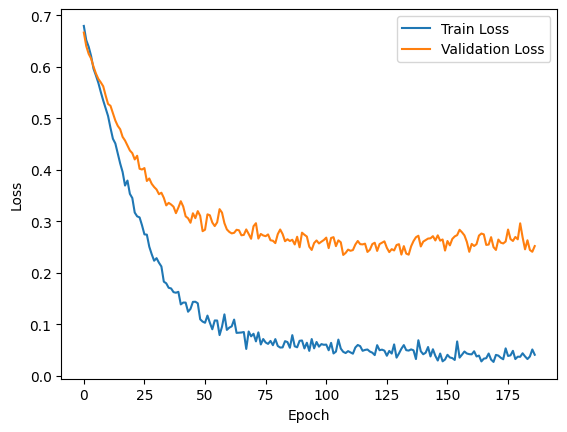

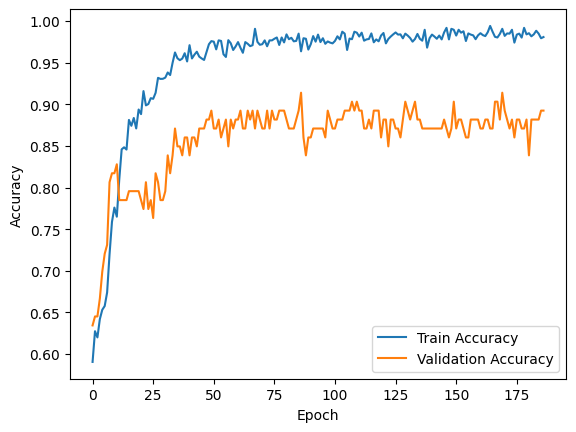

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 1


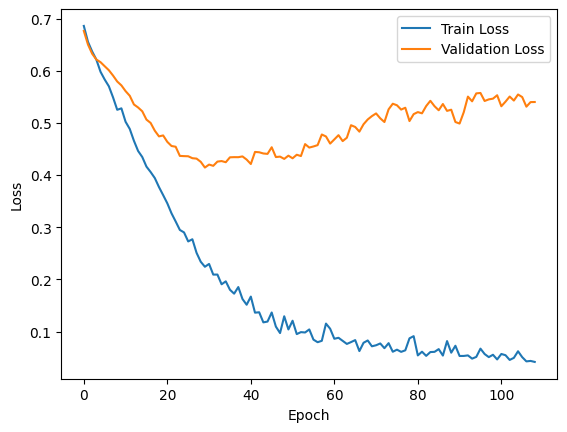

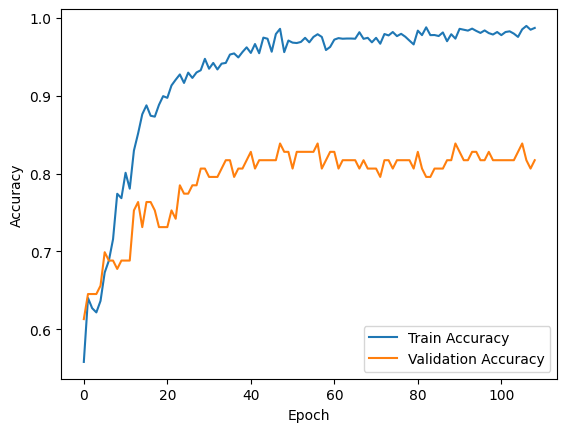

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 2


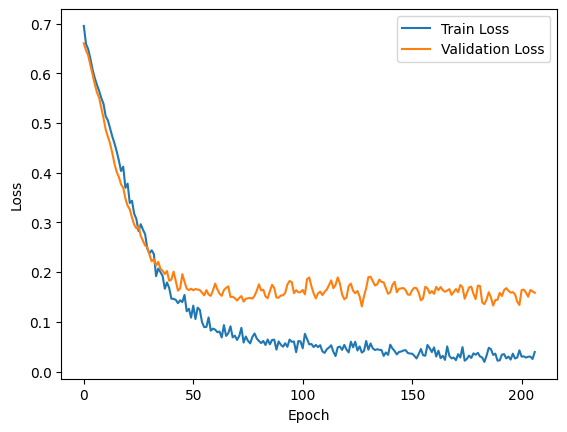

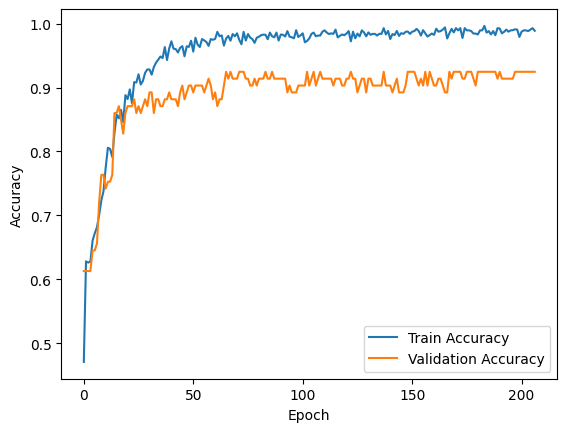

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 3


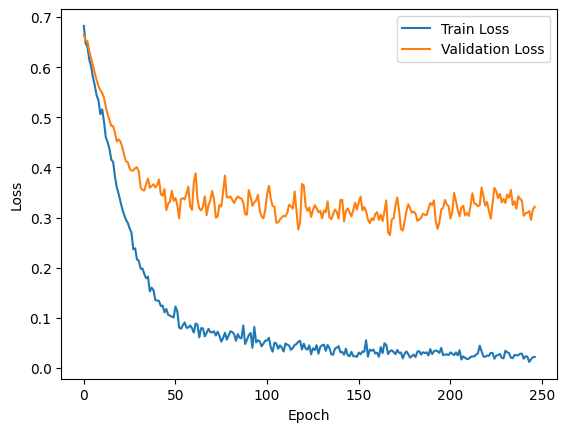

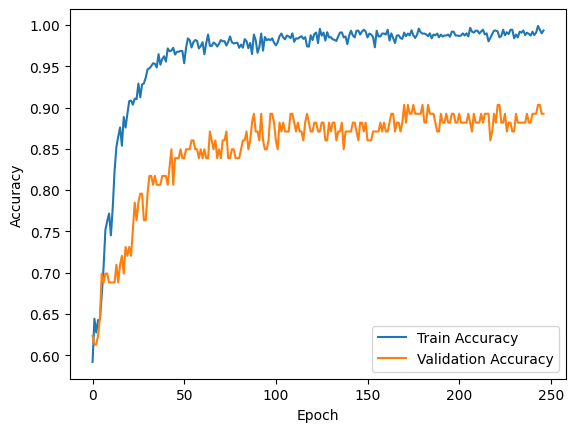

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 4


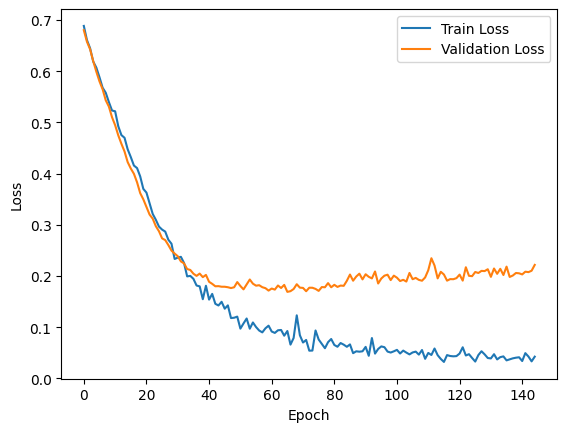

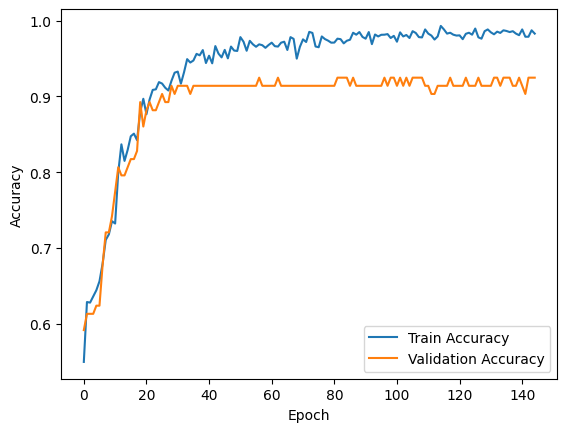

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 5


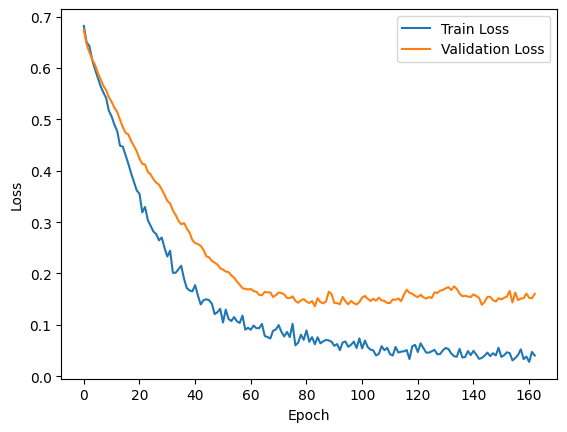

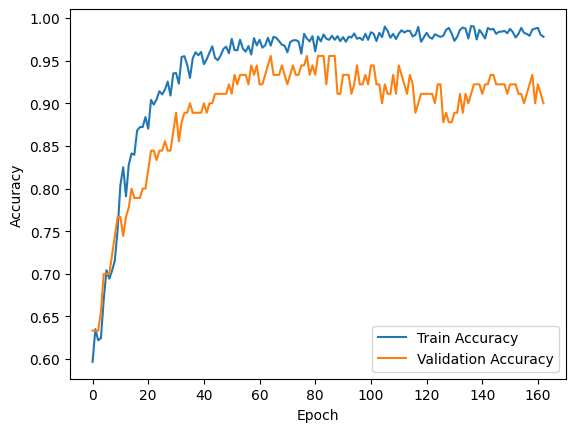

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 6


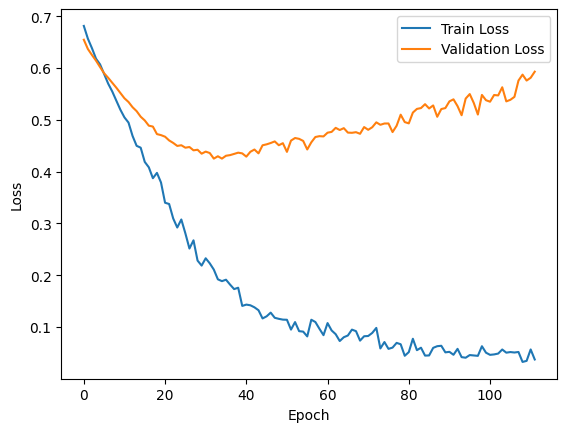

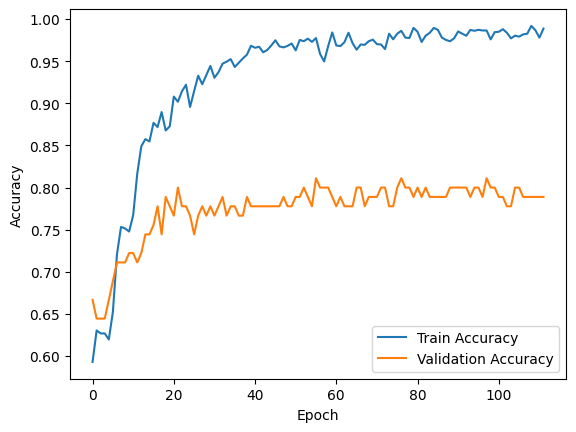

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 7


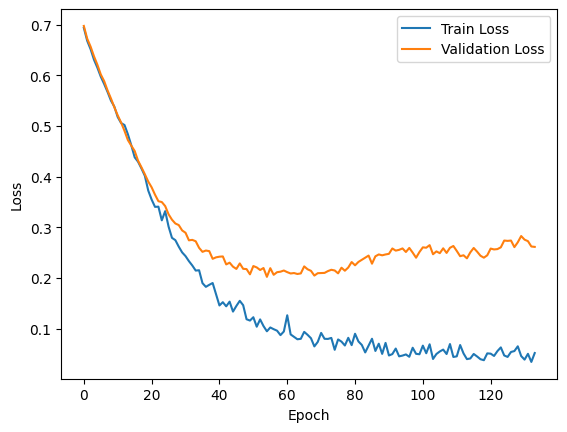

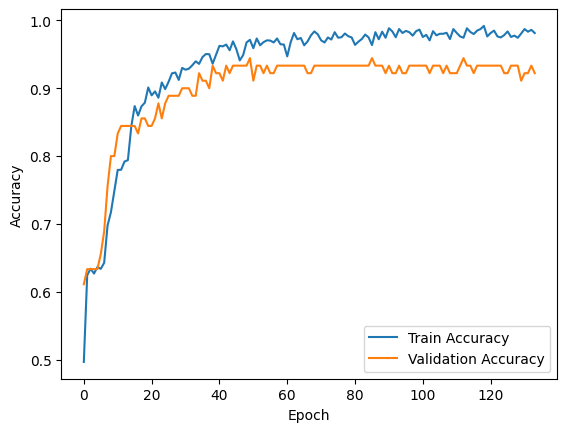

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 8


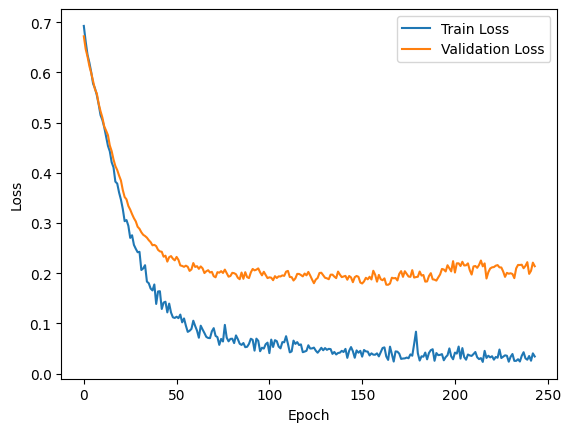

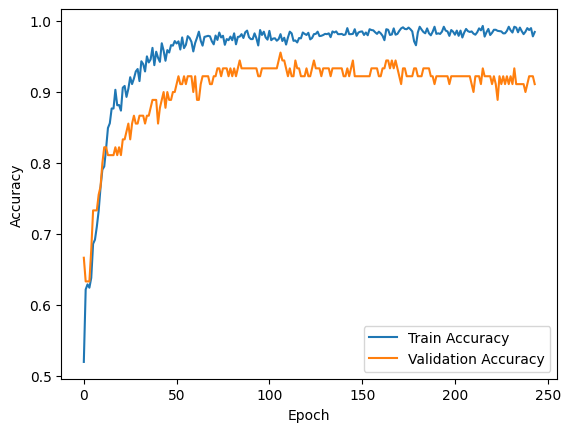

MODEL: resnet50-test-more-params-stratified-kfold-sgd DATASET: foggia-unbalanced-ext FOLD: 9


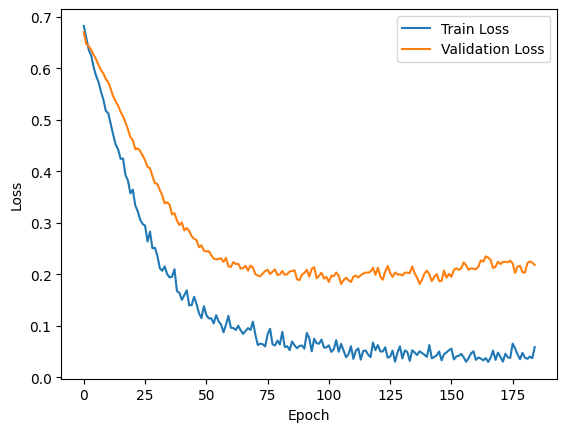

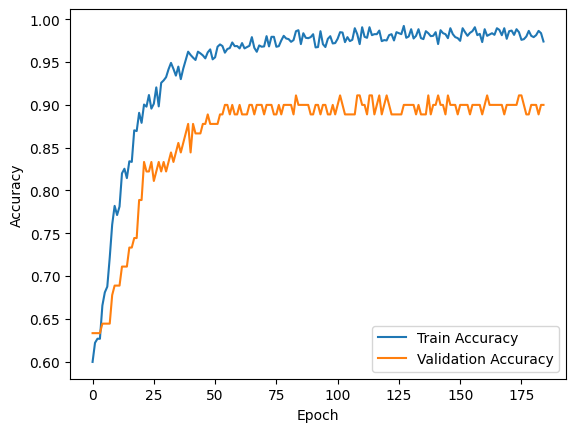

In [1]:
from utils.training import plot_acc
from utils.training import plot_loss

model = "resnet50-test-more-params-stratified-kfold-sgd"
dataset = "foggia-unbalanced-ext"
num_fold = 10

for n in range(10):
    print("MODEL: "+model + " DATASET: "+dataset + " FOLD: "+str(n) )
    path_csv = "experiments/"+model+"/"+dataset+"/fold_"+str(n)+"_training.csv"
#path_csv = "fold_1_training.csv"
    plot_loss(path_csv)
    plot_acc( path_csv)

In [39]:
import glob

for experiment in glob.glob("experiments/*/*"):
    if not os.path.exists(os.path.join(experiment, "best_models.csv")):
        continue
    print(experiment)
    df = print_kfold_results(experiment)
    df2_mean = df[["val_acc", "val_loss", "train_acc", "train_loss"]].mean()
    df2_std = df[["val_acc", "val_loss", "train_acc", "train_loss"]].std()
    df2_std_err = df2_std/math.sqrt(10)
    df2 = pd.DataFrame([df2_mean, df2_std, df2_std_err], index=["mean", "std", "std_err"])
    #display(df2)
    nuovi_nomi_colonne = {
        'train_loss': 'Train Loss',
        'train_acc': 'Train Accuracy',
        'val_loss': 'Validation Loss',
        'val_acc': 'Validation Accuracy',
        'fold': 'Fold',
        'model' : 'Model'
        # Aggiungi altre colonne come necessario
    }

    df = df.rename(columns=nuovi_nomi_colonne)
    colonne_da_elim = ['experiment_name', 'optimizer', 'scheduler','loss_function','epochs','batch_size', 'early_stopping_patience', 'n_folds', 'lr', 'eps', 'weight_decay', 'mode', 'factor', 'patience', 'min_lr', 'momentum']
    column_to_move = df.pop("Fold")
    df.insert(0, "Fold", column_to_move)
    column_to_move = df.pop("Model")
    df.insert(0, "Model", column_to_move)
    model = df["Model"].iloc[0]
    experiment_name = experiment.split("/",maxsplit=1)[1]
    df = df.drop(columns=colonne_da_elim, errors='ignore')
    if not os.path.exists(f"tables/{experiment_name}"):
        os.makedirs(f"tables/{experiment_name}")
    with open(os.path.join("tables",experiment_name,"folds"+'.tex'), 'w') as f:
        f.write(df.to_latex(index=False,escape=True, column_format="|l|r|l|l|l|l|").replace("\\\n", "\\ \hline\n").replace("\\toprule", "\\toprule \\hline"))
    with open(os.path.join("tables",experiment_name,"stats"+'.tex'), 'w') as f:
        f.write(df2.to_latex(index=True,escape=True, column_format="|l|l|l|l|l|").replace("\\\n", "\\ \hline\n").replace("\\toprule", "\\toprule \\hline"))

experiments/mobilenet-v3l-more-params-best/foggia-unbalanced-ext
Mean val_acc: 0.8589247345924378
Standard deviation val_acc: 0.060471993118824625
Standard error: 0.019122923290551506
With 0.95 probability the mean is in the interval: 0.8206788880113348 0.8971705811735408
experiments/YOLOv8n-cls-bin-lower-batch-size/foggia-unbalanced
Mean val_acc: 0.9144999921321869
Standard deviation val_acc: 0.04062816963220723
Standard error: 0.012847755320146028
With 0.95 probability the mean is in the interval: 0.8888044814918948 0.940195502772479
experiments/resnet50-test-more-params-stratified-kfold/foggia-unbalanced-ext
Mean val_acc: 0.90960573554039
Standard deviation val_acc: 0.05391953400102996
Standard error: 0.01705085378181464
With 0.95 probability the mean is in the interval: 0.8755040279767607 0.9437074431040193
experiments/resnet50-test-more-params-stratified-kfold/foggia-unbalanced
Mean val_acc: 0.8862777888774872
Standard deviation val_acc: 0.049431653470010654
Standard error: 0.0156

In [37]:
from models.mobilenet_v3_large import mobilenet_v3l
from models.mobilenet_v3_small import mobilenet_v3s

mobilenet_v3l(2)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [38]:
from models.yolo_v8_cls import yolov8n_cls_more_params
yolov8n_cls_more_params(2)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 